In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib import cm
import xarray as xr
import pandas as pd
import datetime
import warnings # Silence the warnings from SHARPpy
warnings.filterwarnings("ignore")
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import scipy
import scipy.stats
import math
from metpy.interpolate import cross_section
from shapely.geometry import Polygon, Point, MultiPoint, GeometryCollection
import shapely.geometry as geometry
from shapely import concave_hull
import cmweather
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import measure
from skimage.draw import ellipse, polygon, polygon_perimeter
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage import data, io, segmentation, color
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from shapely.validation import make_valid
import glob
import os
from metpy.units import units 

In [8]:
d = {}
d_full = {}

In [12]:
lower_shear = [8]
upper_shear = [31]

path = '/data/keeling/a/melinda3/CM1_OT_shear_UTLS_static_stab_codes/'
for li in lower_shear:
    for ui in upper_shear:
        """hash = 'areas_elhodo_test_'+str(li)+'_'+str(ui)+'_1m_dss_full.csv'
        file_in = pd.read_csv(path+hash)
        file_in = file_in.replace(-9999, np.nan)
        d_full["area{0}_{1}_dss".format(li, ui)] = file_in
        
        hash = 'areas_elhodo_test_'+str(li)+'_'+str(ui)+'_1m_lss_full.csv'
        file_in = pd.read_csv(path+hash)
        file_in = file_in.replace(-9999, np.nan)
        d_full["area{0}_{1}_lss".format(li, ui)] = file_in

        hash = 'areas_elhodo_test_'+str(li)+'_'+str(ui)+'_1m_hss_full.csv'
        file_in = pd.read_csv(path+hash)
        file_in = file_in.replace(-9999, np.nan)
        d_full["area{0}_{1}_hss".format(li, ui)] = file_in

        hash = 'areas_elhodo_test_'+str(li)+'_'+str(ui)+'_1m_lss15_full.csv'
        file_in = pd.read_csv(path+hash)
        file_in = file_in.replace(-9999, np.nan)
        d_full["area{0}_{1}_l15".format(li, ui)] = file_in"""

        hash = 'areas_elhodo_test_'+str(li)+'_'+str(ui)+'_1m_hss15_full.csv'
        file_in = pd.read_csv(path+hash)
        file_in = file_in.replace(-9999, np.nan)
        d_full["area{0}_{1}_h15_sslip".format(li, ui)] = file_in



In [7]:
d = d_full

In [9]:
d['area6_33_h15']

,Unnamed: 0,ota,uca,srh,bshear3,lapse_rate,n2,wmax_trop,up_top,up_bot,bshear6,cape,wmax_core
0,0,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
1,1,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
2,2,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
3,3,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
4,4,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,331.0,195.5,252.71437,14.604588,2.589275,0.000342,53.511684,16.125,3.125,33.41231,3647.603333,37.659309
96,96,333.0,198.5,252.71437,14.604588,2.589275,0.000342,53.391762,16.125,3.375,33.41231,3647.603333,37.134056
97,97,326.5,197.5,252.71437,14.604588,2.589275,0.000342,54.346279,16.125,3.375,33.41231,3647.603333,36.748760
98,98,310.5,198.5,252.71437,14.604588,2.589275,0.000342,55.607430,16.125,3.375,33.41231,3647.603333,36.417175


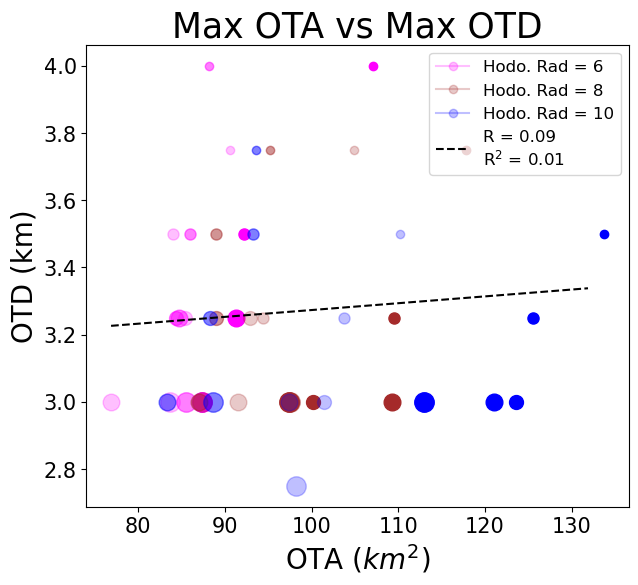

In [6]:
f1 = plt.figure(figsize = (7,6))
plt.title('Max OTA vs Max OTD', fontsize = 25)
plt.xlabel('OTA ($km^{2}$)', fontsize = 20)
plt.ylabel('OTD (km)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['up_top'] 
        ota_lss = ota_lss - 13.375
        uca_lss = d[key]['ota'] *.5 *.5
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['up_top']
        ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['ota']*.5 *.5
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['up_top']
        ota_dss = ota_dss - 13.375
        uca_dss = d[key]['ota']*.5 *.5
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['up_top']
        ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['ota']*.5 *.5
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['up_top']
        ota_hss = ota_hss - 13.375
        uca_hss = d[key]['ota']*.5 *.5
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 5)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


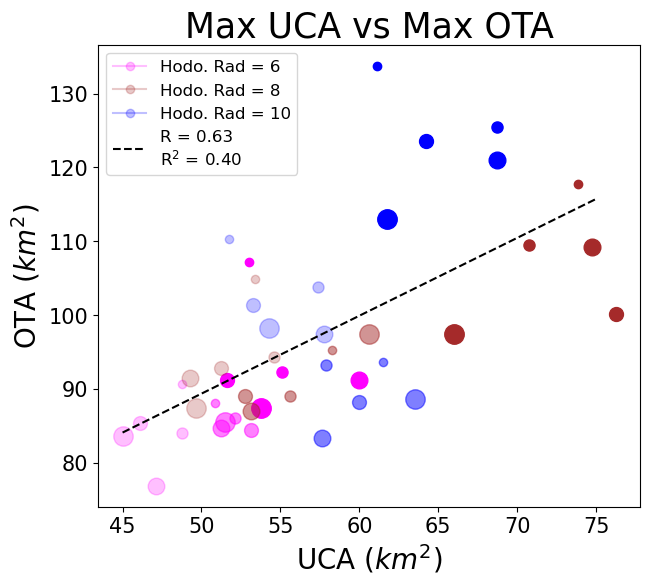

In [13]:
f1 = plt.figure(figsize = (7,6))
plt.title('Max UCA vs Max OTA', fontsize = 25)
plt.xlabel('UCA ($km^{2}$)', fontsize = 20)
plt.ylabel('OTA ($km^{2}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['ota'] *.5 *.5
        #ota_lss = ota_lss - 13.375
        uca_lss = d[key]['uca'] *.5 *.5
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['ota'] *.5 *.5
        #ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['uca']*.5 *.5
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['ota'] *.5 *.5
        #ota_dss = ota_dss - 13.375
        uca_dss = d[key]['uca']*.5 *.5
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['ota']*.5 *.5
        #ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['uca']*.5 *.5
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['ota'] *.5 *.5
        #ota_hss = ota_hss - 13.375
        uca_hss = d[key]['uca']*.5 *.5
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 5)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


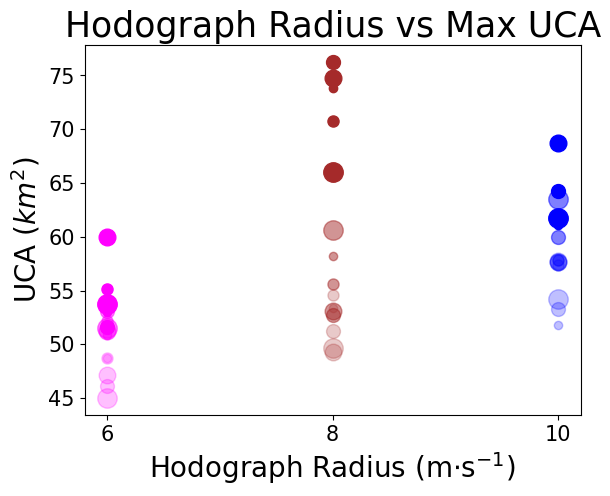

In [16]:
f1 = plt.figure()
plt.title('Hodograph Radius vs Max UCA', fontsize = 25)
plt.xlabel('Hodograph Radius (m$\cdot$s$^{-1}$)', fontsize = 20)
plt.ylabel('UCA ($km^{2}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

all_max_ota = []
all_max_uca = []
max_uca_dss = []
max_uca_lss = []
max_uca_hss = []
hodo_r = []
ota_dss_all = []
ota_hss_all = []
ota_lss_all = []
max_uca_l15 = []
max_uca_h15 = []
ota_l15_all = []
ota_h15_all = []

bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['uca']*.5 *.5
        #ota_lss = ota_lss - 13.375
        if "6" in key:
            hodo_r = key[4]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6)
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)                         
        elif "8" in key:
            hodo_r = key[4]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6)
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)    
        else:
            hodo_r = key[4:6]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6)
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6) 

    if "l15" in key:
        ota_l15 = d[key]['uca']*.5 *.5
        #ota_l15 = ota_l15 - 13.375
        if "6" in key:
            hodo_r = key[4]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)                         
        elif "8" in key:
            hodo_r = key[4]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)    
        else:
            hodo_r = key[4:6]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8) 
    if "dss" in key:
        ota_dss = d[key]['uca']*.5 *.5
        #ota_dss = ota_dss - 13.375
        if "6" in key:
            hodo_r = key[4]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)                         
        elif "8" in key:
            hodo_r = key[4]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)    
        else:
            hodo_r = key[4:6]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10) 
    if "h15" in key:
        ota_h15 = d[key]['uca']*.5 *.5
        #ota_h15 = ota_h15 - 13.375
        if "6" in key:
            hodo_r = key[4]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)                         
        elif "8" in key:
            hodo_r = key[4]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)    
        else:
            hodo_r = key[4:6]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12) 
    if "hss" in key:
        ota_hss = d[key]['uca'] *.5 *.5
        #ota_hss = ota_hss - 13.375
        if "6" in key:
            hodo_r = key[4]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)                         
        elif "8" in key:
            hodo_r = key[4]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)    
        else:
            hodo_r = key[4:6]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14) 

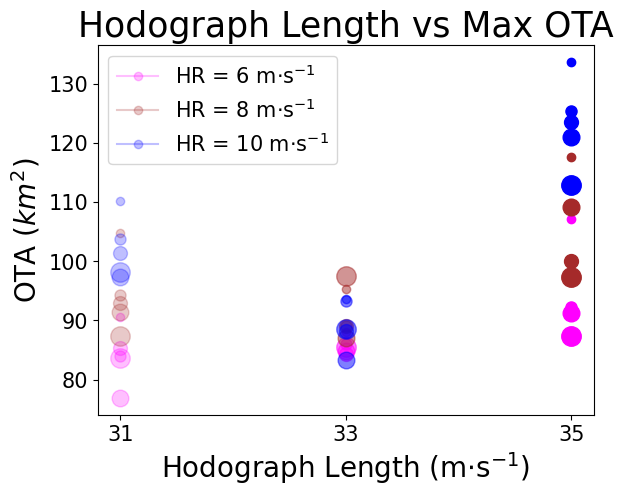

In [18]:
f1 = plt.figure()
plt.title('Hodograph Length vs Max OTA', fontsize = 25)
plt.xlabel('Hodograph Length (m$\cdot$s$^{-1}$)', fontsize = 20)
plt.ylabel('OTA ($km^{2}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


all_max_ota = []
all_max_uca = []
max_uca_dss = []
max_uca_lss = []
max_uca_hss = []
hodo_r = []
ota_dss_all = []
ota_hss_all = []
ota_lss_all = []
max_uca_l15 = []
max_uca_h15 = []
ota_l15_all = []
ota_h15_all = []

bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['ota'] *.5*.5
        #ota_lss = ota_lss - 13.375
        if "6" in key:
            hodo_r = key[6:8]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6,\
                    label = 'HR = 6 m$\cdot$s$^{-1}$')
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)                         
        elif "8" in key:
            hodo_r = key[6:8]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6,\
                    label = 'HR = 8 m$\cdot$s$^{-1}$')
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)    
        else:
            hodo_r = key[7:9]
            max_uca_lss.append(hodo_r)
            max_ota_lss = np.max(ota_lss)
            ota_lss_all.append(max_ota_lss)
            bshear_lss = d[key]['bshear6'][5]
            if bshear_lss < first_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6,\
                    label = 'HR = 10 m$\cdot$s$^{-1}$')
            elif first_terc < bshear_lss < second_terc:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(hodo_r, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6) 

    if "l15" in key:
        ota_l15 = d[key]['ota'] *.5*.5
        #ota_l15 = ota_l15 - 13.375
        if "6" in key:
            hodo_r = key[6:8]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)                         
        elif "8" in key:
            hodo_r = key[6:8]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)    
        else:
            hodo_r = key[7:9]
            max_uca_l15.append(hodo_r)
            max_ota_l15 = np.max(ota_l15)
            ota_l15_all.append(max_ota_l15)
            bshear_l15 = d[key]['bshear6'][5]
            if bshear_l15 < first_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
            elif first_terc < bshear_l15 < second_terc:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(hodo_r, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8) 
    if "dss" in key:
        ota_dss = d[key]['ota'] *.5*.5
        #ota_dss = ota_dss - 13.375
        if "6" in key:
            hodo_r = key[6:8]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)                         
        elif "8" in key:
            hodo_r = key[6:8]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)    
        else:
            hodo_r = key[7:9]
            max_uca_dss.append(hodo_r)
            max_ota_dss = np.max(ota_dss)
            ota_dss_all.append(max_ota_dss)
            bshear_dss = d[key]['bshear6'][5]
            if bshear_dss < first_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
            elif first_terc < bshear_dss < second_terc:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(hodo_r, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10) 
    if "h15" in key:
        ota_h15 = d[key]['ota'] *.5*.5
        #ota_h15 = ota_h15 - 13.375
        if "6" in key:
            hodo_r = key[6:8]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)                         
        elif "8" in key:
            hodo_r = key[6:8]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)    
        else:
            hodo_r = key[7:9]
            max_uca_h15.append(hodo_r)
            max_ota_h15 = np.max(ota_h15)
            ota_h15_all.append(max_ota_h15)
            bshear_h15 = d[key]['bshear6'][5]
            if bshear_h15 < first_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
            elif first_terc < bshear_h15 < second_terc:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(hodo_r, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12) 
    if "hss" in key:
        ota_hss = d[key]['ota'] *.5*.5
        #ota_hss = ota_hss - 13.375
        if "6" in key:
            hodo_r = key[6:8]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)                         
        elif "8" in key:
            hodo_r = key[6:8]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)    
        else:
            hodo_r = key[7:9]
            max_uca_hss.append(hodo_r)
            max_ota_hss = np.max(ota_hss)
            ota_hss_all.append(max_ota_hss)
            bshear_hss = d[key]['bshear6'][5]
            if bshear_hss < first_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
            elif first_terc < bshear_hss < second_terc:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(hodo_r, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14) 
plt.legend(fontsize = 15, loc = 'best')

In [1]:
f1 = plt.figure(figsize = (7,6))
#plt.title('${\Gamma}$ vs Max OTA', fontsize = 25)
plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
#plt.xlabel('${\Gamma}$ ($^\circ$C$\cdot$$km^{-1}$)', fontsize = 20)
plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('OTA ($km^{2}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ticklabel_format(axis = 'x', style = 'scientific', scilimits=(2,4))
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['ota'] *.5 *.5
        #ota_lss = ota_lss - 13.375
        uca_lss = d[key]['n2']
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['ota']*.5 *.5
        #ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['n2']
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['ota']*.5 *.5
        #ota_dss = ota_dss - 13.375
        uca_dss = d[key]['n2']
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['ota']*.5 *.5
        #ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['n2']
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['ota']*.5 *.5
        #ota_hss = ota_hss - 13.375
        uca_hss = d[key]['n2']
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.000005)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


NameError: name 'plt' is not defined

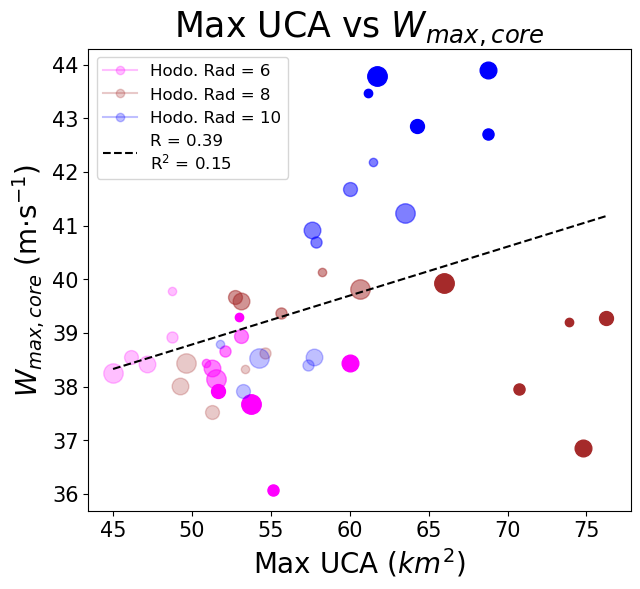

In [11]:
f1 = plt.figure(figsize = (7,6))
plt.title('Max UCA vs $W_{max,core}$', fontsize = 25)
#plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
plt.xlabel('Max UCA ($km^{2}$)', fontsize = 20)
#plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('$W_{max,core}$ (m$\cdot$s$^{-1}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['wmax_core']
        #ota_lss = ota_lss - 13.375
        uca_lss = d[key]['uca'] *.5 *.5
        #uca_lss = uca_lss - 13.375
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['wmax_core']
        #ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['uca'] *.5 *.5
        #uca_l15 = uca_l15 - 13.375
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['wmax_core']
        #ota_dss = ota_dss - 13.375
        uca_dss = d[key]['uca'] *.5 *.5
        #uca_dss = uca_dss - 13.375
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['wmax_core']
        #ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['uca'] *.5 *.5
        #uca_h15 = uca_h15 - 13.375
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['wmax_core']
        #ota_hss = ota_hss - 13.375
        uca_hss = d[key]['uca'] *.5 *.5
        #uca_hss = uca_hss - 13.375
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.001)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


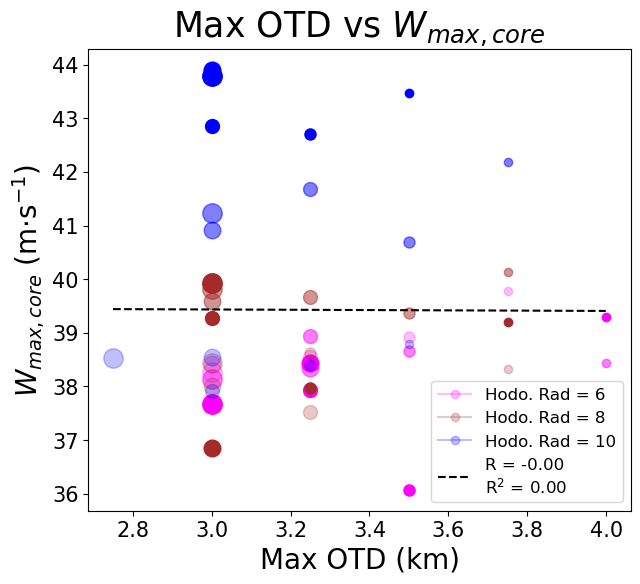

In [10]:
f1 = plt.figure(figsize = (7,6))
plt.title('Max OTD vs $W_{max,core}$', fontsize = 25)
#plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
plt.xlabel('Max OTD (km)', fontsize = 20)
#plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('$W_{max,core}$ (m$\cdot$s$^{-1}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['wmax_core']
        #ota_lss = ota_lss - 13.375
        uca_lss = d[key]['up_top']
        uca_lss = uca_lss - 13.375
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['wmax_core']
        #ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['up_top']
        uca_l15 = uca_l15 - 13.375
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['wmax_core']
        #ota_dss = ota_dss - 13.375
        uca_dss = d[key]['up_top']
        uca_dss = uca_dss - 13.375
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['wmax_core']
        #ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['up_top']
        uca_h15 = uca_h15 - 13.375
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['wmax_core']
        #ota_hss = ota_hss - 13.375
        uca_hss = d[key]['up_top']
        uca_hss = uca_hss - 13.375
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.001)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


In [15]:
d['area8_33_dss']['wmax_trop']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
121    0.0
122    0.0
123    0.0
124    0.0
125    0.0
Name: wmax_trop, Length: 126, dtype: float64

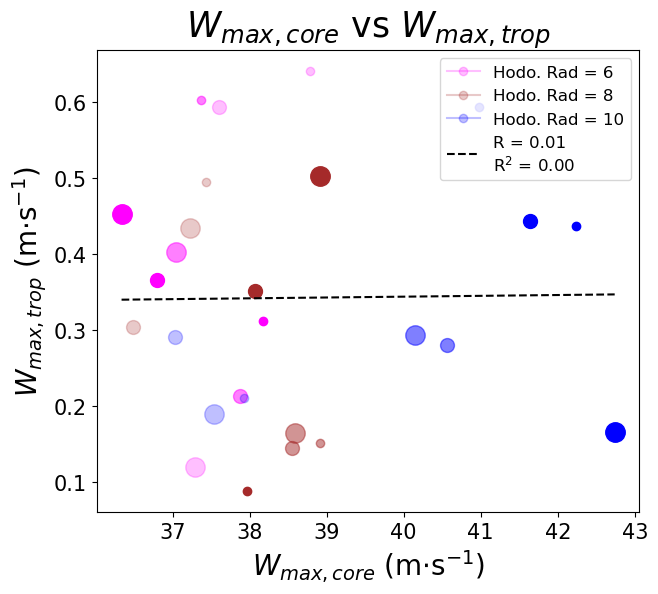

In [13]:
f1 = plt.figure(figsize = (7,6))
plt.title('$W_{max,core}$ vs $W_{max,trop}$', fontsize = 25)
#plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
plt.xlabel('$W_{max,core}$ (m$\cdot$s$^{-1}$)', fontsize = 20)
#plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('$W_{max,trop}$ (m$\cdot$s$^{-1}$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['wmax_trop']
        #ota_lss = ota_lss - 13.375
        uca_lss = d[key]['wmax_core']
        #uca_lss = uca_lss - 13.375
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['wmax_trop']
        #ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['wmax_core']
        #uca_l15 = uca_l15 - 13.375
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['wmax_trop']
        #ota_dss = ota_dss - 13.375
        uca_dss = d[key]['wmax_core']
        #uca_dss = uca_dss - 13.375
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['wmax_trop']
        #ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['wmax_core']
        #uca_h15 = uca_h15 - 13.375
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['wmax_trop']
        #ota_hss = ota_hss - 13.375
        uca_hss = d[key]['wmax_core']
        #uca_hss = uca_hss - 13.375
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.001)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


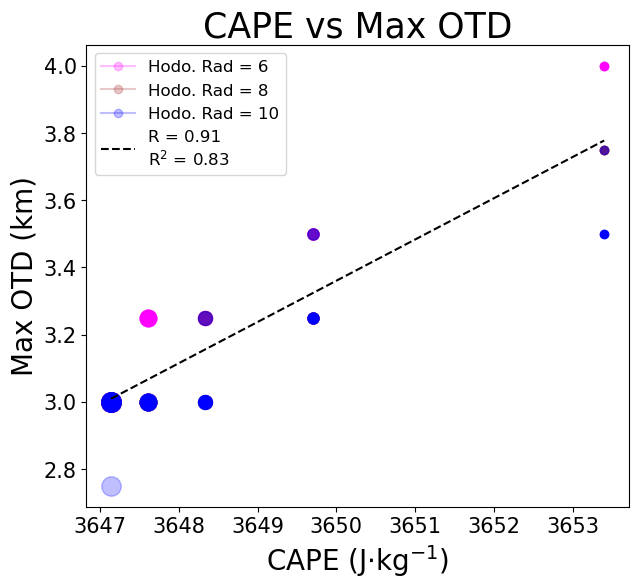

In [21]:
f1 = plt.figure(figsize = (7,6))
plt.title('CAPE vs Max OTD', fontsize = 25)
#plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
plt.xlabel('CAPE (J$\cdot$kg$^{-1}$)', fontsize = 20)
#plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('Max OTD (km)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['up_top']
        ota_lss = ota_lss - 13.375
        uca_lss = d[key]['cape']
        #uca_lss = uca_lss - 13.375
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['up_top']
        ota_l15 = ota_l15 - 13.375
        uca_l15 = d[key]['cape']
        #uca_l15 = uca_l15 - 13.375
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['up_top']
        ota_dss = ota_dss - 13.375
        uca_dss = d[key]['cape']
        #uca_dss = uca_dss - 13.375
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['up_top']
        ota_h15 = ota_h15 - 13.375
        uca_h15 = d[key]['cape']
        #uca_h15 = uca_h15 - 13.375
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['up_top']
        ota_hss = ota_hss - 13.375
        uca_hss = d[key]['cape']
        #uca_hss = uca_hss - 13.375
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.001)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


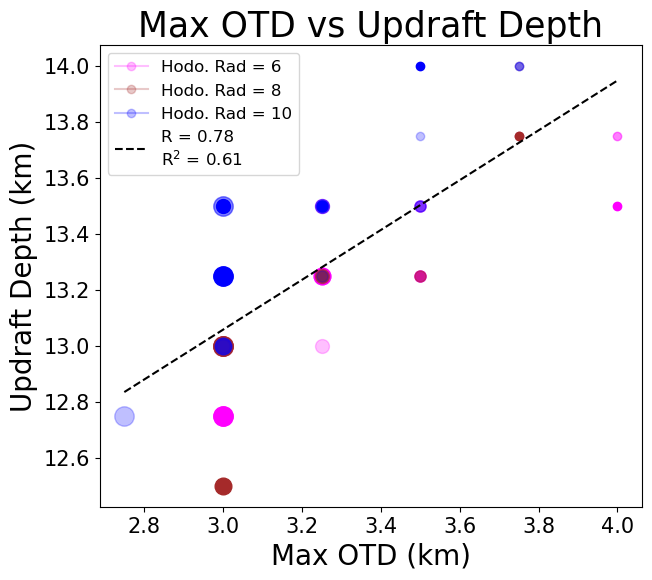

In [25]:
f1 = plt.figure(figsize = (7,6))
plt.title('Max OTD vs Updraft Depth', fontsize = 25)
#plt.title('$N^{2}$ vs Max OTA', fontsize = 25)
plt.xlabel('Max OTD (km)', fontsize = 20)
#plt.xlabel('$N^{2}$ s$^{-2}$', fontsize = 15)
plt.ylabel('Updraft Depth (km)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
all_max_uca = []
all_max_ota = []
bshear6 = []
for key in d:
    bshear6.append(d[key]['bshear6'][5])

#Get the shear terciles
first_terc = np.percentile(bshear6, 33.3333)
second_terc = np.percentile(bshear6, 66.6666)

for key in d:
    if "lss" in key:
        ota_lss = d[key]['up_top']
        ota_lss = ota_lss - d[key]['up_bot']
        uca_lss = d[key]['up_top']
        uca_lss = uca_lss - 13.375
        bshear_lss = d[key]['bshear6'][0]
        max_ota_lss = np.max(ota_lss)
        max_uca_lss = np.max(uca_lss)
        all_max_uca.append(max_uca_lss)
        all_max_ota.append(max_ota_lss)

        if bshear_lss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 6')
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 8')
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.25, markersize = 6, \
                    label = 'Hodo. Rad = 10')
        elif first_terc < bshear_lss < second_terc:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 0.5, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 0.5, markersize = 6)
        else:
            if "6" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 6)
            elif "8" in key:
                plt.plot(max_uca_lss, max_ota_lss, color = 'brown', marker = "o", alpha = 1, markersize = 6)
            else:
                plt.plot(max_uca_lss, max_ota_lss, color = 'blue', marker = "o", alpha = 1, markersize = 6)
    if "l15" in key:
        ota_l15 = d[key]['up_top']
        ota_l15 = ota_l15 - d[key]['up_bot']
        uca_l15 = d[key]['up_top']
        uca_l15 = uca_l15 - 13.375
        bshear_l15 = d[key]['bshear6'][0]
        max_ota_l15 = np.max(ota_l15)
        max_uca_l15 = np.max(uca_l15)
        all_max_uca.append(max_uca_l15)
        all_max_ota.append(max_ota_l15)
        if bshear_l15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.25, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.25, markersize = 8)
        elif first_terc < bshear_l15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 0.5, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 0.5, markersize = 8)
        else:
            if "6" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 8)
            elif "8" in key:
                plt.plot(max_uca_l15, max_ota_l15, color = 'brown', marker = "o", alpha = 1, markersize = 8)
            else:
                plt.plot(max_uca_l15, max_ota_l15, color = 'blue', marker = "o", alpha = 1, markersize = 8)
    if "dss" in key:
        ota_dss = d[key]['up_top']
        ota_dss = ota_dss - d[key]['up_bot']
        uca_dss = d[key]['up_top']
        uca_dss = uca_dss - 13.375
        bshear_dss = d[key]['bshear6'][0]
        max_ota_dss = np.max(ota_dss)
        max_uca_dss = np.max(uca_dss)
        all_max_uca.append(max_uca_dss)
        all_max_ota.append(max_ota_dss)
        if bshear_dss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.25, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.25, markersize = 10)
        elif first_terc < bshear_dss < second_terc:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 0.5, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 0.5, markersize = 10)
        else:
            if "6" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 10)
            elif "8" in key:
                plt.plot(max_uca_dss, max_ota_dss, color = 'brown', marker = "o", alpha = 1, markersize = 10)
            else:
                plt.plot(max_uca_dss, max_ota_dss, color = 'blue', marker = "o", alpha = 1, markersize = 10)
    if "h15" in key:
        ota_h15 = d[key]['up_top']
        ota_h15 = ota_h15 - d[key]['up_bot']
        uca_h15 = d[key]['up_top']
        uca_h15 = uca_h15 - 13.375
        bshear_h15 = d[key]['bshear6'][0]
        max_ota_h15 = np.max(ota_h15)
        max_uca_h15 = np.max(uca_h15)
        all_max_uca.append(max_uca_h15)
        all_max_ota.append(max_ota_h15)
        if bshear_h15 <= first_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.25, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.25, markersize = 12)
        elif first_terc < bshear_h15 < second_terc:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 0.5, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 0.5, markersize = 12)
        else:
            if "6" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'fuchsia', marker = "o", alpha = 1, markersize = 12)
            elif "8" in key:
                plt.plot(max_uca_h15, max_ota_h15, color = 'brown', marker = "o", alpha = 1, markersize = 12)
            else:
                plt.plot(max_uca_h15, max_ota_h15, color = 'blue', marker = "o", alpha = 1, markersize = 12)
    if "hss" in key:
        ota_hss = d[key]['up_top']
        ota_hss = ota_hss - d[key]['up_bot']
        uca_hss = d[key]['up_top']
        uca_hss = uca_hss - 13.375
        bshear_hss = d[key]['bshear6'][0]
        max_ota_hss = np.max(ota_hss)
        max_uca_hss = np.max(uca_hss)
        all_max_uca.append(max_uca_hss)
        all_max_ota.append(max_ota_hss)
        if bshear_hss <= first_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.25, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.25, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.25, markersize = 14)
        elif first_terc < bshear_hss < second_terc:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 0.5, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 0.5, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 0.5, markersize = 14)
        else:
            if "6" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'fuchsia', marker = "o", alpha = 1, markersize = 14)
            elif "8" in key:
                plt.plot(max_uca_hss, max_ota_hss, color = 'brown', marker = "o", alpha = 1, markersize = 14)
            else:
                plt.plot(max_uca_hss, max_ota_hss, color = 'blue', marker = "o", alpha = 1, markersize = 14)

uca_ota_model = scipy.stats.linregress(all_max_uca, all_max_ota)
r_value = uca_ota_model.rvalue
r2_val = r_value ** 2
b_val = uca_ota_model.intercept
m_val = uca_ota_model.slope
x_vals = np.arange(min(all_max_uca), max(all_max_uca), 0.001)

y_vals = (x_vals*m_val) + b_val
plt.plot(x_vals, y_vals, ls = "--", color = 'k', \
    label = 'R = %0.2f\n'%r_value + "R$^2$ = %0.2f"%r2_val )
plt.legend(loc = 'best', fontsize = 12)


In [22]:
d['area6_33_h15']

,Unnamed: 0,ota,uca,srh,bshear3,lapse_rate,n2,wmax_trop,up_top,up_bot,bshear6,cape,wmax_core
0,0,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
1,1,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
2,2,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
3,3,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
4,4,NaN,NaN,252.71437,14.604588,2.589275,0.000342,NaN,NaN,NaN,33.41231,3647.603333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,331.0,195.5,252.71437,14.604588,2.589275,0.000342,53.511684,16.125,3.125,33.41231,3647.603333,37.659309
96,96,333.0,198.5,252.71437,14.604588,2.589275,0.000342,53.391762,16.125,3.375,33.41231,3647.603333,37.134056
97,97,326.5,197.5,252.71437,14.604588,2.589275,0.000342,54.346279,16.125,3.375,33.41231,3647.603333,36.748760
98,98,310.5,198.5,252.71437,14.604588,2.589275,0.000342,55.607430,16.125,3.375,33.41231,3647.603333,36.417175


In [17]:
#Plot time series of the area data for UCA and OTA
ota_area_8_sslip = d_full['area8_31_h15_sslip']['ota'][45:100]
ota_area_8_fslip = d_full['area8_31_h15_fslip']['ota'][45:100]

ota_area_10_sslip = d_full['area10_35_h15_sslip']['ota'][45:100]
ota_area_10_fslip = d_full['area10_35_h15_fslip']['ota'][45:100]

times = np.arange(len(ota_area_8_fslip))

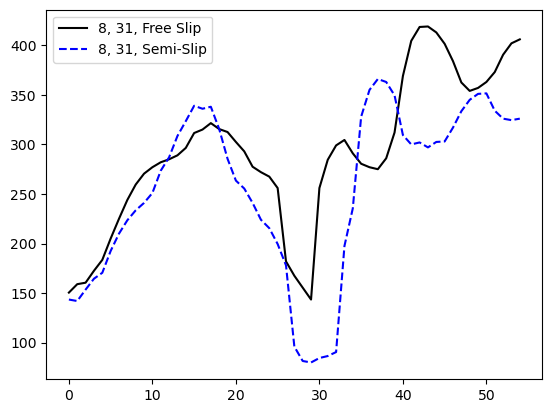

In [19]:
#Plot the area time series

plt.plot(times, ota_area_8_fslip, label = '8, 31, Free Slip', color = 'k')
plt.plot(times, ota_area_8_sslip, label = '8, 31, Semi-Slip', color = 'blue', ls = '--')


plt.legend()

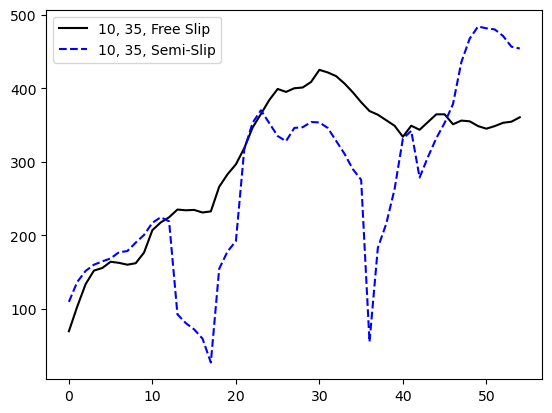

In [20]:
plt.plot(times, ota_area_10_fslip, label = '10, 35, Free Slip', color = 'k')
plt.plot(times, ota_area_10_sslip, label = '10, 35, Semi-Slip', color = 'blue', ls = '--')

plt.legend()

In [21]:
#Plot time series of the area data for UCA and OTA
uca_area_8_sslip = d_full['area8_31_h15_sslip']['uca'][45:100]
uca_area_8_fslip = d_full['area8_31_h15_fslip']['uca'][45:100]

uca_area_10_sslip = d_full['area10_35_h15_sslip']['uca'][45:100]
uca_area_10_fslip = d_full['area10_35_h15_fslip']['uca'][45:100]

times = np.arange(len(ota_area_8_fslip))

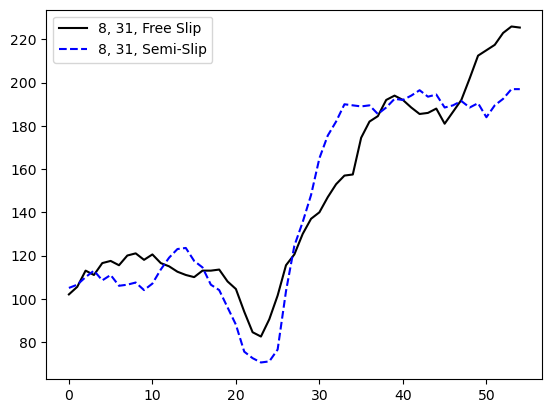

In [22]:
#Plot the area time series

plt.plot(times, uca_area_8_fslip, label = '8, 31, Free Slip', color = 'k')
plt.plot(times, uca_area_8_sslip, label = '8, 31, Semi-Slip', color = 'blue', ls = '--')


plt.legend()

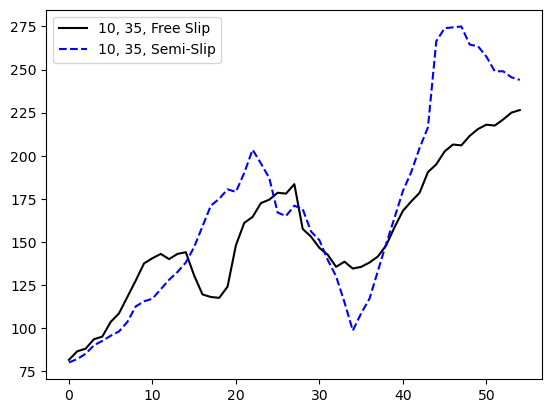

In [23]:
plt.plot(times, uca_area_10_fslip, label = '10, 35, Free Slip', color = 'k')
plt.plot(times, uca_area_10_sslip, label = '10, 35, Semi-Slip', color = 'blue', ls = '--')

plt.legend()